# Option pricing with CVA
<font color ="#4169e1">Pricing an option with a risky counterparty under the framework of the Merton Credit-risk model </font>

## <font color ='#caa520'> Merton model </font>

The Merton model in Credit Risk is a structural Credit Risk model where the **Value of equity (S)** is modelled as a **call option on the firm's assets**.


<center><b><font color ="#4169e1">Value of the firm (V) </font>= Value of the debt (D) + Value of the equity (S)</b> <br>
    <b><font color ="#4169e1">Value of equity (S) </font> = Value of firm’s assets (V) – Value of risky debt (D) </b></center> 

Also, risky debt is modelled as the difference of risk-free debt and a put option on the firm's assets:

$$ De^{-rT} - P(V_0, r \sigma, D, T) $$ 

The call and put options are priced using the usual analytical Black-Scholes formula and the all its  assumptions:

$$ Put = V_0 \Phi(-d_1) + (1 - \Phi(-d_2))De^{-rT} \\
d_1 = \frac{ln(\frac{V_0}{D}) + (r + \frac{\sigma^2}{2})T}{\sigma \sqrt{T}} \\
d_2 = d_1 - \sigma \sqrt{T} $$

### The Merton Model’s assumptions are:
- Simple capital structure: one class of equity + one zero-coupon bond
- Value of firm can be observed
- Value follows a lognormal diffusion process
- Default only occurs at maturity
- Riskless interest rates are constant
- Debt is not renegotiated
- No liquidity adjustment

### Steps in Merton Model
1) Use the Black-Scholes-Merton option-pricing model (BSM OPM) to estimate the price (value) of the firm's equity <br>
2) Using the firm's equity value to assume the firm's asset value and asset volatility, estimate the probability of default (PD) under an assumption that the firm's asset price will follow a lognormal distribution

### From risk neutral to real world: PD under the Merton model
The default probability using the Merton approach and applying the Black-Scholes-Merton formula
is as follows:

$$ PD = \Phi(-d_2)$$ 

Except a key point is that the drift used in finding the default probability is **NOT** the risk-free rate as in the Black-Scholes model for risk-neutral pricing. For finding the default probability, a real world drift μ is used in the formula.
- another important point is that this last step of finding N(-d2) to find the default probabilty implied the assumption of normal returns (Advanced models such as KMV do not utilise this assumption)

## <font color ='caa520'> Credit Value Adjustment (CVA) </font>

CVA is the expected value or price of counterparty credit risk. Therefore, <b>RiskyValue</b> = Analytical Price - CVA. 


$$CVA = \mathbb{E}^{Q}[e^{-r\tau}(1-\delta) V(\tau) 𝟙_{\tau\leq	T}] $$
$$CVA = (1-\delta)  \sum_{j=1}^{m} EE(t_j)  q(t_{j-1}, t_j)   $$

where
* **Loss given default (LGD)**: LGD = (1-recovery rate)
* **Discount factors**: B(t[j]) gives the risk-free discount factor at time t[j].
* **EE (Expected exposure)**: EE(t[j]) is the expected exposure (EE) for the relevant dates in the future given by t[j] for j = 0, n>m.<br>
* **Default Probability**: The expression q(t[j-1], t[j]) gives the marginal default probability in the interval between date t[j+1] and t[j].

### Credit exposures

EPE is used in the CVA spread formula, but there are also other types of exposures. Its is important to note that counterparty risk arises only when you have +ve exposure to the counterparty.

- **Expected mark to market (MtM)** is the expected value of a transaction at a given point in the future.

- **Expected exposure (EE)** is the amount that is expected to be lost if there is positive MtM and the counterparty defaults. Expected exposure is larger than expected MtM because EE considers both positive and negative MtM values. 

- **Potential future exposure (PFE)** is an estimate of MtM value at a specific point in the future. It is usually based on a high confidence level, taking into account the worst-case scenario.

- **Expected positive exposure (EPE)** is the average Expected Exposure (EE) through time. Expected positive exposure is a useful single amount to quantify exposure.

## <font color ='gold'> Calculating CVA for an option</font>

We will now use the EPE (average EE through time) to price a risky option under the Black-Scholes assumptions including the assumption that the firm follows GBM:
$$ dV_t = rV_tdt + \sigma V_t dW_t $$ 

Remember, RiskyValue = Analytical Price - CVA. We will calculate the analytical price using the regular Black-Scholes formula and use all the assumptions of the Merton model for calculating the CVA.

In [2]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import random as r

In [3]:
risk_free = 0.05

#Stock
S_0 = 100
sigma = 0.25

#Call Option 
strike = 110
T = 1

#Firm 
V_0 = 200
sigma_firm = 0.25
debt = 180
recovery_rate = 0.1

We are defining the terminal value based on the assumption of normality. This terminal value function will be used both for the stock as well as the counterparty firm. The variable **Z** is a multivariate normal sample.

In [4]:
#Generates the terminal share price given Z
def terminal_value(S_0, risk_free_rate, sigma, Z, T):
    return S_0*np.exp((risk_free_rate-sigma**2/2)*T+sigma*np.sqrt(T)*Z)
    
#Evaluating the call price in Monte Carlo Estimation
def call_payoff(S_T, K):
    return np.maximum(S_T-K, 0)

Setting a seed value so that the code is replicable

In [5]:
np.random.seed(0)

corr_tested = np.linspace(-1,1,21)
cva_estimates = [None]*len(corr_tested)
cva_std = [None]*len(corr_tested)

np.linspace returns evenly spaced numbers over a specified interval. Here the interval is from -1 to 1 for correlation, and we are drawing 21 samples.

In [6]:
corr_tested

array([-1. , -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,
        0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ])

For each correlation we will produce a CVA estimate and a CVA standard deviation as follows:
* We need to account for two conditions, when correlation is +1/-1 and when correlation is between the two values
* We use **norm.rvs(size = np.array([2,50000]))** which creates a matrix of two columns with values from 0 to 50000
* We use the terminal_value function defined above to create an array of stock values by substituting **Z** with **corr_norm_matrix[0,]**
* Similarly we create terminal firm values by substituting **Z** with **corr_norm_matrix[1,]**


In [7]:
for i in range(len(corr_tested)):
    
    correlation = corr_tested[i]
    if (correlation == 1 or correlation == -1):
        norm_vec_0 = norm.rvs(size = 50000)
        norm_vec_1 = correlation*norm_vec_0
        corr_norm_matrix = np.array([norm_vec_0, norm_vec_1])
        
    else:
        corr_matrix = np.array([[1, correlation], [correlation,1]])
        norm_matrix = norm.rvs(size = np.array([2,50000]))
        corr_norm_matrix = np.matmul(np.linalg.cholesky(corr_matrix), norm_matrix)
     
    # create an array of stock values using the first row of the matrix of correlated standard normals. 
    term_stock_val = terminal_value(S_0, risk_free, sigma, corr_norm_matrix[0,], T)
    
    # create an array of call values for the given stock values.
    call_val = call_payoff(term_stock_val, strike)
    
    # create an array of terminal firm values.
    term_firm_val = terminal_value(V_0, risk_free, sigma_firm, corr_norm_matrix[1,], T)
    
    # Using the call values in the formula
    amount_lost = np.exp(-risk_free*T)*(1-recovery_rate)*(term_firm_val < debt)*call_val
    cva_estimates[i] = np.mean(amount_lost)
    cva_std[i] = np.std(amount_lost)/np.sqrt(50000)

The first **if** loop says that if the correlation is either -1 or +1, we create a **corr_norm_matrix** by multiplying a column of 1 to 50,000 which is **norm_vector_0** with another matrix which is a **scalar** multiplied with the a column of 1 to 50,000

The **else** condition is that if the correlation is between -1 and +1, we multiply the defined **corr_matrix** with the **norm_matrix**

In [8]:
# Calculating probability of default
d_1 = (np.log(V_0/debt) + (risk_free + sigma_firm**2/2)*(T))/(sigma_firm*np.sqrt(T))
d_2 = d_1 - sigma_firm*np.sqrt(T)

default_prob = norm.cdf(-d_2)

Again, it is important to note that this is **not** the risk neutral world anymore (when we are finding the default probability). The drift used in finding the default probability is NOT the risk-free rate as in the Black-Scholes model. For finding the default probability, a real world drift μ (sigma) is used in the formula.

In [9]:
#Analytical pricing using the Black-Scholes option pricing model
d_1_stock = (np.log(V_0/debt) + (risk_free + sigma**2/2)*(T))/(sigma_firm*np.sqrt(T))
d_2_stock = d_1_stock - sigma*np.sqrt(T)

analytic_callprice = S_0*norm.cdf(d_1_stock) - strike*np.exp(-risk_free*(T))*norm.cdf(d_2_stock)

In [11]:
uncorr_cva = (1-recovery_rate)*default_prob*analytic_callprice

* **uncorr_cva** is the the static CVA which doesn't consider the correlation of the firm values. It uses the Black-Scholes price for a call option.
* **cva_estimates** are the CVA estimates which change with the correlation between the firm and the portfolio.

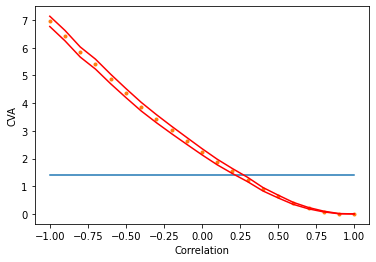

In [14]:
plt.plot(corr_tested, [uncorr_cva]*21)
plt.plot(corr_tested, cva_estimates, ".")
plt.plot(corr_tested, cva_estimates + 3*np.array(cva_std), "r")
plt.plot(corr_tested, cva_estimates - 3*np.array(cva_std), "r")
plt.xlabel("Correlation")
plt.ylabel("CVA")
plt.show()

We can see that CVA is highest when the correlation is the lowest.

## <font color ='gold'> References</font>

* Merton model, a summary of issues (https://forum.bionicturtle.com/threads/merton-model-a-summary-of-the-issues.5646/)
* Arnaud de Servigny, "Measuring and Managing Credit Risk"
* FRM Part 2 coursebook, Kaplan Schweser, "Credit Risk Measurement and Management"
* WQU notes, Computational Finance 